In [1]:
%load_ext watermark

ModuleNotFoundError: No module named 'watermark'

In [2]:
%watermark -d -v -a 'Sebastian Raschka' -p scikit-learn,nltk,numpy

ERROR:root:Line magic function `%watermark` not found.


<font size="1.5em">[More information](https://github.com/rasbt/watermark) about the `watermark` magic command extension.</font>

<br>
<br>

# Lyrics Mood Classification - Training

<br>
<br>

### Sections

- [Preprocessing](#Preprocessing)
    - [Reading the dataset](#Reading-the-dataset)
    - [Label Encoder](#Label-Encoder)
    - [Feature extraction: Word counts and Vectorizers](#Feature-extraction:-Word-counts-and-Vectorizers)
        - [Porter Stemmer](#Porter-Stemmer)
        - [Stop word list](#Stop-word-list)
        - [Count Vectorizer](#Count-Vectorizer)
        - [Tfidf Vectorizer](#Tfidf-Vectorizer)
- [Model Selection](#Model-Selection)
    - [Grid search and hyperparameter tuning](#Grid-search-and-hyperparameter-tuning)
        - [Grid Search](#Grid-Search)
        - [Grid Search ROC Curves](#Grid-Search-ROC-Curves)
        - [Hyperparameter tuning 1 - max_features](#Hyperparameter-tuning-1---max_features)
        - [Hyperparameter tuning 2 - min_df](#Hyperparameter-tuning-2---min_df)
        - [Hyperparameter tuning 3 - alpha](#Hyperparameter-tuning-3---alpha)
- [Validation](#Validation)
    - [Confusion matrix](#Confusion-matrix)
    - [ROC AUC, Accuracy, Precision, Recall, and F1-score](#ROC-AUC,-Accuracy,-Precision,-Recall,-and-F1-score)
- [Save classifier](#Save-classifier)

<br>
<br>

# Preprocessing

[[back to top](#Sections)]

<br>
<br>

### Reading the dataset

[[back to top](#Sections)]

In [3]:
import pandas as pd

df = pd.read_csv('../../dataset/training/train_lyrics_1000.csv')

df.head()

,file,artist,title,lyrics,genre,mood,year
0,TRAAAAW128F429D538.h5,Casual,I Didn't Mean To,Verse One:\n\nAlright I might\nHave had a litt...,Hip Hop/Rap,sad,1994
1,TRAAAEF128F4273421.h5,Adam Ant,Something Girls,Adam Ant/Marco Pirroni\nEvery girl is a someth...,Rock,happy,1982
2,TRAAAFD128F92F423A.h5,Gob,Face the Ashes,"I've just erased it's been a while, I've got a...",Rock,sad,2007
3,TRAABJV128F1460C49.h5,Lionel Richie,Tonight Will Be Alright,Little darling \nWhere you've been so long \nI...,R&B,happy,1986
4,TRAABLR128F423B7E3.h5,Blue Rodeo,Floating,"Lead Vocal by Greg\n\nWell, these late night c...",Rock,sad,1987


<br>
<br>

### Label Encoder

[[back to top](#Sections)]

In [27]:
from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np

X_train = df['lyrics'].values 

y_train = df['mood'].values

print('before: %s ..' %y_train[:5])

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

print('after: %s ...' %y_train[:5])

before: ['sad' 'happy' 'sad' 'happy' 'sad'] ..
after: [1 0 1 0 1] ...


In [5]:
# Save object to disk

import pickle

pickle_out = open('./lyrics_label_encoder_py.pkl', 'wb')
pickle.dump(le, pickle_out)
pickle_out.close()

<br>
<br>

## Feature extraction: Word counts and Vectorizers

[[back to top](#Sections)]

<br>
<br>

### Porter Stemmer

[[back to top](#Sections)]

In [6]:
# Porter Stemmer

import nltk
import string
import re

porter_stemmer = nltk.stem.porter.PorterStemmer()

def porter_tokenizer(text, stemmer=porter_stemmer):
    """
    A Porter-Stemmer-Tokenizer hybrid to splits sentences into words (tokens) 
    and applies the porter stemming algorithm to each of the obtained token. 
    Tokens that are only consisting of punctuation characters are removed as well.
    Only tokens that consist of more than one letter are being kept.
    
    Parameters
    ----------
        
    text : `str`. 
      A sentence that is to split into words.
        
    Returns
    ----------
    
    no_punct : `str`. 
      A list of tokens after stemming and removing Sentence punctuation patterns.
    
    """
    lower_txt = text.lower()
    tokens = nltk.wordpunct_tokenize(lower_txt)
    stems = [porter_stemmer.stem(t) for t in tokens]
    no_punct = [s for s in stems if re.match('^[a-zA-Z]+$', s) is not None]
    return no_punct


#### Test

In [29]:
porter_tokenizer("Don't !!! --- want swi.mming. ")

['don', 't', 'want', 'swi', 'mming']

<br>
<br>

### Stop word list

[[back to top](#Sections)]

In [30]:
# Commented out to prevent overwriting files:
#
# stp = nltk.corpus.stopwords.words('english')
# with open('./stopwords_eng.txt', 'w') as outfile:
#    outfile.write('\n'.join(stp))
    
    
with open('./stopwords_eng.txt', 'r') as infile:
    stop_words = infile.read().splitlines()
print('stop words %s ...' %stop_words[:7])

stop words ['i', 'me', 'my', 'myself', 'we', 'our', 'ours'] ...


<br>
<br>

### Count Vectorizer

[[back to top](#Sections)]

In [9]:
# Count Vectorizer

from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(
            encoding='utf-8',
            decode_error='replace',
            strip_accents='unicode',
            analyzer='word',
            binary=False,
            stop_words=stop_words,
            tokenizer=porter_tokenizer,
            ngram_range=(1,1)
    )


#### Test 1

In [10]:
vocab = ["123 1 The\n swimmer likes swimming so he swims. Don't didn`t"]

vec = vec.fit(vocab)

sentence1 = vec.transform([u'The swimmer likes swimming.'])
sentence2 = vec.transform(['The\nswimmer \nswims.'])


print('TEST:')
print('Vocabulary: %s' %vec.get_feature_names())
print('Sentence 1: %s' %sentence1.toarray())
print('Sentence 2: %s' %sentence2.toarray())

TEST:
Vocabulary: ['didn', 'like', 'swim', 'swimmer']
Sentence 1: [[0 1 1 1]]
Sentence 2: [[0 0 1 1]]


#### Fitting the lyrics

In [11]:
vec = vec.fit(X_train.ravel())

In [12]:
print('Vocabulary size: %s' %len(vec.get_feature_names()))

Vocabulary size: 8550


#### Test 2 (N-grams = 2)

In [13]:
vec = CountVectorizer(
            encoding='utf-8',
            decode_error='replace',
            strip_accents='unicode',
            analyzer='word',
            binary=False,
            stop_words=stop_words,
            tokenizer=porter_tokenizer,
            ngram_range=(2,2)
    )

vocab = ["123 1 The\n swimmer likes swimming so he swims. Don't didn`t"]

vec = vec.fit(vocab)

sentence1 = vec.transform([u'The swimmer likes swimming.'])
sentence2 = vec.transform(['The\nswimmer \nswims.'])


print('TEST:')
print('Vocabulary: %s' %vec.get_feature_names())
print('Sentence 1: %s' %sentence1.toarray())
print('Sentence 2: %s' %sentence2.toarray())

TEST:
Vocabulary: ['like swim', 'swim didn', 'swim swim', 'swimmer like']
Sentence 1: [[1 0 0 1]]
Sentence 2: [[0 0 0 0]]


<br>
<br>

### Tfidf Vectorizer

[[back to top](#Sections)]

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
            encoding='utf-8',
            decode_error='replace',
            strip_accents='unicode',
            analyzer='word',
            binary=False,
            stop_words=stop_words,
            tokenizer=porter_tokenizer
    )

#### Test

In [15]:
vocab = ["123 1 The\n swimmer likes swimming so he swims. Don't didn`t"]

tfidf = tfidf.fit(vocab)

sentence1 = tfidf.transform([u'The swimmer likes swimming.'])
sentence2 = tfidf.transform(['The\nswimmer \nswims.'])


print('TEST:')
print('Vocabulary: %s' %tfidf.get_feature_names())
print('Sentence 1: %s' %sentence1.toarray())
print('Sentence 2: %s' %sentence2.toarray())

TEST:
Vocabulary: ['didn', 'like', 'swim', 'swimmer']
Sentence 1: [[0.         0.57735027 0.57735027 0.57735027]]
Sentence 2: [[0.         0.         0.70710678 0.70710678]]


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


#### Fitting the lyrics

In [16]:
tfidf = tfidf.fit(X_train.ravel())

print('Vocabulary size: %s' %len(tfidf.get_feature_names()))

Vocabulary size: 8550


<br>
<br>

# Model Selection

[[back to top](#Sections)]

<br>
<br>

### Grid search and hyperparameter tuning

[[back to top](#Sections)]

<br>
<br>

#### Models: Multivariate Bernoulli and Multinomial naive Bayes

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline

#### Performance metric: F1-score

In [18]:
# Custom scorer methods to account for positive-negative class labels

from sklearn import metrics

# `pos_label` for positive class, since we have sad=1, happy=0

f1_scorer = metrics.make_scorer(metrics.f1_score, greater_is_better=True, pos_label=0)

<br>
<br>

#### Grid Search

[[back to top](#Sections)]

In [21]:
from sklearn.grid_search import GridSearchCV
from pprint import pprint

pipeline_1 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', BernoulliNB())
])

parameters_1 = dict(
    vect__binary=[True],
    vect__stop_words=[stop_words, None],
    vect__tokenizer=[porter_tokenizer, None],
    vect__ngram_range=[(1,1), (2,2), (3,3)],
)

grid_search_1 = GridSearchCV(pipeline_1, 
                           parameters_1, 
                           n_jobs=1, 
                           verbose=1,
                           scoring=f1_scorer,
                           cv=10
                )


print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_1.steps])
print("parameters:")
pprint(parameters_1, depth=2)
grid_search_1.fit(X_train, y_train)
print("Best score: %0.3f" % grid_search_1.best_score_)
print("Best parameters set:")
best_parameters_1 = grid_search_1.best_estimator_.get_params()
for param_name in sorted(parameters_1.keys()):
    print("\t%s: %r" % (param_name, best_parameters_1[param_name]))

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__binary': [True],
 'vect__ngram_range': [(...), (...), (...)],
 'vect__stop_words': [[...], None],
 'vect__tokenizer': [<function porter_tokenizer at 0x000001D2CD3B2400>, None]}
Fitting 10 folds for each of 12 candidates, totalling 120 fits


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: 

Best score: 0.617
Best parameters set:
	vect__binary: True
	vect__ngram_range: (1, 1)
	vect__stop_words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 

In [22]:
from sklearn.grid_search import GridSearchCV

pipeline_3 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

parameters_3 = dict(
    vect__binary=[False],
    vect__stop_words=[stop_words, None],
    vect__tokenizer=[porter_tokenizer, None],
    vect__ngram_range=[(1,1), (2,2), (3,3)],
)

grid_search_3 = GridSearchCV(pipeline_3, 
                           parameters_3, 
                           n_jobs=1, 
                           verbose=1,
                           scoring=f1_scorer,
                           cv=10
                )


print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_3.steps])
print("parameters:")
pprint(parameters_3, depth=2)
grid_search_3.fit(X_train, y_train)
print("Best score: %0.3f" % grid_search_3.best_score_)
print("Best parameters set:")
best_parameters_3 = grid_search_3.best_estimator_.get_params()
for param_name in sorted(parameters_3.keys()):
    print("\t%s: %r" % (param_name, best_parameters_3[param_name]))

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__binary': [False],
 'vect__ngram_range': [(...), (...), (...)],
 'vect__stop_words': [[...], None],
 'vect__tokenizer': [<function porter_tokenizer at 0x000001D2CD3B2400>, None]}
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  9.6min finished


Best score: 0.620
Best parameters set:
	vect__binary: False
	vect__ngram_range: (1, 1)
	vect__stop_words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',

In [23]:
from sklearn.grid_search import GridSearchCV

pipeline_4 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

parameters_4 = dict(
    vect__binary=[False],
    vect__stop_words=[stop_words, None],
    vect__tokenizer=[porter_tokenizer, None],
    vect__ngram_range=[(1,1), (2,2), (3,3)],
)

grid_search_4 = GridSearchCV(pipeline_4, 
                           parameters_4, 
                           n_jobs=1, 
                           verbose=1,
                           scoring=f1_scorer,
                           cv=10
                )


print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_4.steps])
print("parameters:")
pprint(parameters_4, depth=2)
grid_search_4.fit(X_train, y_train)
print("Best score: %0.3f" % grid_search_4.best_score_)
print("Best parameters set:")
best_parameters_4 = grid_search_4.best_estimator_.get_params()
for param_name in sorted(parameters_4.keys()):
    print("\t%s: %r" % (param_name, best_parameters_4[param_name]))

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__binary': [False],
 'vect__ngram_range': [(...), (...), (...)],
 'vect__stop_words': [[...], None],
 'vect__tokenizer': [<function porter_tokenizer at 0x000001D2CD3B2400>, None]}
Fitting 10 folds for each of 12 candidates, totalling 120 fits


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-

Best score: 0.335
Best parameters set:
	vect__binary: False
	vect__ngram_range: (2, 2)
	vect__stop_words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


<br>
<br>

#### Grid Search ROC Curves

[[back to top](#Sections)]

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-

FileNotFoundError: [Errno 2] No such file or directory: './images/roc_gridsearch_1.eps'

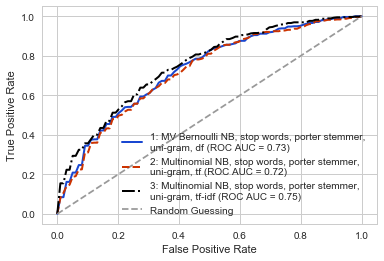

In [25]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")

clf_1 = Pipeline([
                  ('vect', CountVectorizer(
                                           binary=True,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', BernoulliNB()),
                 ])

clf_2 = Pipeline([
                  ('vect', CountVectorizer(
                                           binary=False,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', MultinomialNB()),
                 ])

clf_3 = Pipeline([
                  ('vect', TfidfVectorizer(
                                           binary=False,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', MultinomialNB()),
                 ])

colors = ['#1947D1', '#CC3300', 'k']
linestyles = ['-', '--', '-.']
classifiers = [clf_1, clf_2, clf_3]
labels = ['1: MV Bernoulli NB, stop words, porter stemmer, \nuni-gram, df', 
          '2: Multinomial NB, stop words, porter stemmer, \nuni-gram, tf',
          '3: Multinomial NB, stop words, porter stemmer, \nuni-gram, tf-idf',
          ]

for clf,col,ls,lab in zip(classifiers, colors, linestyles, labels):
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    cv = StratifiedKFold(y_train, n_folds=10, random_state=123)

    for i, (train, test) in enumerate(cv):
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, 
             mean_tpr, 
             color=col, 
             linestyle=ls,
             label='%s (ROC AUC = %0.2f)' % (lab, mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('./images/roc_gridsearch_1.eps', dpi=300)
plt.show()



<br>
<br>

#### Hyperparameter tuning 1 - max_features

[[back to top](#Sections)]

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\hp\Anaconda3\lib\site-

FileNotFoundError: [Errno 2] No such file or directory: './images/roc_maxfeatures.eps'

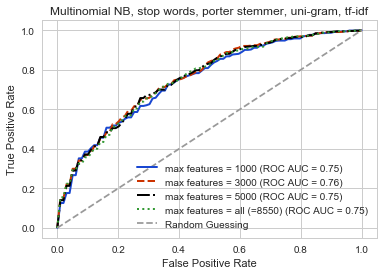

In [26]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")


colors = ['#1947D1', '#CC3300', 'k', '#339933']
linestyles = ['-', '--', '-.', ':']
params = [1000,3000,5000,None]
labels = ['max features = 1000', 
          'max features = 3000',
          'max features = 5000',
          'max features = all (=8550)',
          ]

for param,col,ls,lab in zip(params, colors, linestyles, labels):

    clf = Pipeline([
                         ('vect', TfidfVectorizer(
                                                  binary=False,
                                                  stop_words=stop_words,
                                                  tokenizer=porter_tokenizer,
                                                  ngram_range=(1,1),
                                                  max_features=param,
                                                  )
                          ),
                         ('clf', MultinomialNB()),
                        ])
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    cv = StratifiedKFold(y_train, n_folds=10, random_state=123)

    for i, (train, test) in enumerate(cv):
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, 
             mean_tpr, 
             color=col, 
             linestyle=ls,
             label='%s (ROC AUC = %0.2f)' % (lab, mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multinomial NB, stop words, porter stemmer, uni-gram, tf-idf')
plt.legend(loc="lower right")
plt.savefig('./images/roc_maxfeatures.eps', dpi=300)
plt.show()


<br>
<br>

#### Hyperparameter tuning 2 - min_df

[[back to top](#Sections)]

In [ ]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")


colors = ['#1947D1', '#CC3300', 'k', ]
linestyles = ['-', '--', '-.']
params = [1, 0.1, 0.01]
labels = ['no cutoff',
          'min. df = 0.1', 
          'min. df = 0.01',
          ]

for param,col,ls,lab in zip(params, colors, linestyles, labels):

    clf = Pipeline([
                         ('vect', TfidfVectorizer(
                                                  binary=False,
                                                  stop_words=stop_words,
                                                  tokenizer=porter_tokenizer,
                                                  ngram_range=(1,1),
                                                  min_df=param,
                                                  )
                          ),
                         ('clf', MultinomialNB()),
                        ])
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    cv = StratifiedKFold(y_train, n_folds=10, random_state=123)

    for i, (train, test) in enumerate(cv):
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, 
             mean_tpr, 
             color=col, 
             linestyle=ls,
             label='%s (ROC AUC = %0.2f)' % (lab, mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Multinomial NB, stop words, porter stemmer, uni-gram, tf-idf')
plt.savefig('./images/roc_mindf.eps', dpi=300)
plt.show()



<br>
<br>

#### Hyperparameter tuning 3 - alpha

[[back to top](#Sections)]

In [ ]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")


colors = ['#1947D1', '#CC3300', 'k', '#339933']
linestyles = ['-', '--', '-.', ':']
params = [0.05, 0.1, 1.0, 2.0]
labels = ['alpha = 0.05', 
          'alpha = 0.1',
          'alpha = 1.0',
          'alpha = 2.0',
          ]

for param,col,ls,lab in zip(params, colors, linestyles, labels):

    clf = Pipeline([
                         ('vect', TfidfVectorizer(
                                                  binary=False,
                                                  stop_words=stop_words,
                                                  tokenizer=porter_tokenizer,
                                                  ngram_range=(1,1),
                                                  
                                                  )
                          ),
                         ('clf', MultinomialNB(alpha=param)),
                        ])
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    cv = StratifiedKFold(y_train, n_folds=10, random_state=123)

    for i, (train, test) in enumerate(cv):
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, 
             mean_tpr, 
             color=col, 
             linestyle=ls,
             label='%s (ROC AUC = %0.2f)' % (lab, mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Multinomial NB, stop words, porter stemmer, uni-gram, tf-idf')
plt.savefig('./images/roc_alpha.eps', dpi=300)
plt.show()

<br>
<br>

#### n-gram comparison

[[back to top](#Sections)]

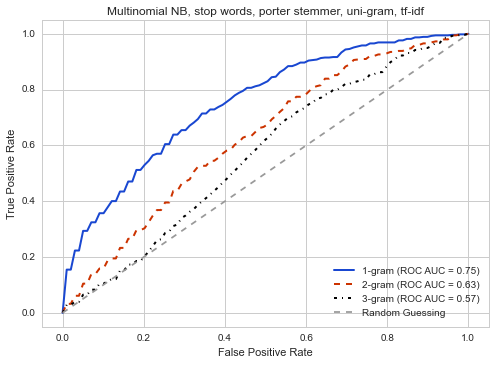

In [212]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")


colors = ['#1947D1', '#CC3300', 'k', ]
linestyles = ['-', '--', '-.',]
params = [(1,1), (2,2), (3,3),]
labels = ['1-gram', 
          '2-gram',
          '3-gram',
          ]

for param,col,ls,lab in zip(params, colors, linestyles, labels):

    clf = Pipeline([
                         ('vect', TfidfVectorizer(
                                                  binary=False,
                                                  stop_words=stop_words,
                                                  tokenizer=porter_tokenizer,
                                                  ngram_range=param,
                                                  
                                                  )
                          ),
                         ('clf', MultinomialNB(alpha=1.0)),
                        ])
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    cv = StratifiedKFold(y_train, n_folds=10, random_state=123)

    for i, (train, test) in enumerate(cv):
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, 
             mean_tpr, 
             color=col, 
             linestyle=ls,
             label='%s (ROC AUC = %0.2f)' % (lab, mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Multinomial NB, stop words, porter stemmer, uni-gram, tf-idf')
plt.savefig('./images/roc_ngrams.eps', dpi=300)
plt.show()

<br>
<br>

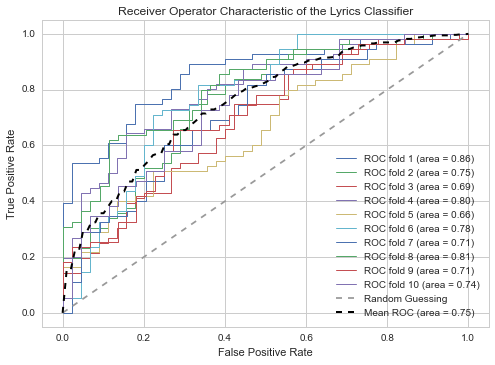

In [22]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")

classifier = Pipeline([
               ('vect', TfidfVectorizer(
                                           binary=False,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', MultinomialNB()),
              ])


cv = StratifiedKFold(y_train, n_folds=10, random_state=123)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas_ = classifier.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic of the Lyrics Classifier')
plt.legend(loc="lower right")
plt.savefig('./images/roc_final.eps', dpi=300)
plt.show()

<br>
<br>

# Validation

[[back to top](#Sections)]

In [19]:
final_clf = Pipeline([
                ('vect', TfidfVectorizer(
                                         binary=False,
                                         stop_words=stop_words,
                                         tokenizer=porter_tokenizer,
                                         ngram_range=(1,1),
                                         )
                ),
                ('clf', MultinomialNB(alpha=1.0)),
               ])
final_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(analyzer=u'word', binary=False, charset=None,
        charset_error=None, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

<br>
<br>

### Confusion matrix

[[back to top](#Sections)]

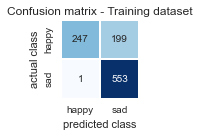

In [30]:
import matplotlib as mpl
import numpy as np

cm = metrics.confusion_matrix(y_train, final_clf.predict(X_train))

np.set_printoptions(suppress=True)
mpl.rc("figure", figsize=(4, 2))

hm = sns.heatmap(cm, 
            cbar=False,
            annot=True, 
            square=True,
            fmt='d',
            yticklabels=['happy','sad'],
            xticklabels=['happy','sad'],
            cmap='Blues'
            )
plt.title('Confusion matrix - Training dataset')
plt.ylabel('actual class')
plt.xlabel('predicted class')
plt.tight_layout()
plt.savefig('./images/confmat_training.eps', dpi=300)
plt.show()

In [31]:
df = pd.read_csv('../../dataset/validation/valid_lyrics_200.csv')

X_valid = df['lyrics'].values 
y_valid = df['mood'].values

y_valid = le.transform(y_valid)

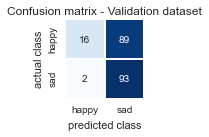

In [32]:
cm = metrics.confusion_matrix(y_valid, final_clf.predict(X_valid))

np.set_printoptions(suppress=True)
mpl.rc("figure", figsize=(4, 2))

hm = sns.heatmap(cm, 
            cbar=False,
            annot=True, 
            square=True,
            fmt='d',
            yticklabels=['happy','sad'],
            xticklabels=['happy','sad'],
            cmap='Blues'
            )
plt.title('Confusion matrix - Validation dataset')
plt.ylabel('actual class')
plt.xlabel('predicted class')
plt.tight_layout()
plt.savefig('./images/confmat_valid.eps', dpi=300)
plt.show()

<br>
<br>

### ROC AUC, Accuracy, Precision, Recall, and F1-score

[[back to top](#Sections)]

In [263]:
# Custom scorer methods to account for positive-negative class labels

from sklearn import metrics

# `pos_label` for positive class, since we have sad=1, happy=0

acc_scorer = metrics.make_scorer(metrics.accuracy_score, greater_is_better=True)
pre_scorer = metrics.make_scorer(metrics.precision_score, greater_is_better=True, pos_label=0)
rec_scorer = metrics.make_scorer(metrics.recall_score, greater_is_better=True, pos_label=0)
f1_scorer = metrics.make_scorer(metrics.f1_score, greater_is_better=True, pos_label=0)
auc_scorer = metrics.make_scorer(metrics.roc_auc_score, greater_is_better=True)

In [307]:
d = {'Data':['Training', 'Validation'],
     'ACC (%)':[],
     'PRE (%)':[],
     'REC (%)':[],
     'F1 (%)':[],
     'ROC AUC (%)':[],
}

In [308]:
d['ACC (%)'].append(acc_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['PRE (%)'].append(pre_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['REC (%)'].append(rec_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['F1 (%)'].append(f1_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['ROC AUC (%)'].append(auc_scorer(estimator=final_clf, X=X_train, y_true=y_train))

d['ACC (%)'].append(acc_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['PRE (%)'].append(pre_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['REC (%)'].append(rec_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['F1 (%)'].append(f1_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['ROC AUC (%)'].append(auc_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))

In [309]:
df_perform = pd.DataFrame(d)
df_perform = df_perform[['ACC (%)', 'PRE (%)', 'REC (%)', 'F1 (%)', 'ROC AUC (%)']]
df_perform.index=(['Training', 'Validation'])
df_perform = df_perform*100
df_perform = np.round(df_perform, decimals=2)
df_perform

,ACC (%),PRE (%),REC (%),F1 (%),ROC AUC (%)
Training,80.0,99.60,55.38,71.18,77.60
Validation,54.5,88.89,15.24,26.02,56.57


In [310]:
df_perform.to_csv('./clf_performance.csv', index_label=False)

<br>
<br>

## Save classifier

[[back to top](#Sections)]

In [20]:
lyrics_clf_1000 = final_clf

pickle_out = open('./lyrics_clf_1000_py27.pkl', 'wb')
pickle.dump(lyrics_clf_1000, pickle_out)
pickle_out.close()

# New pickle objects for webapp

In [13]:
import pickle

pickle_out = open('./lyrics_label_encoder.pkl', 'rb')
le = pickle.load(pickle_out)
pickle_out.close()

In [ ]:

from sklearn.naive_bayes import MultinomialNB

with open('./stopwords_eng.txt', 'r') as infile:
    stop_words = infile.read().splitlines()

In [2]:
# Porter Stemmer

import nltk
import string
import re


porter_stemmer = nltk.stem.porter.PorterStemmer()

def porter_tokenizer(text, stemmer=porter_stemmer):
    """
    A Porter-Stemmer-Tokenizer hybrid to splits sentences into words (tokens) 
    and applies the porter stemming algorithm to each of the obtained token. 
    Tokens that are only consisting of punctuation characters are removed as well.
    Only tokens that consist of more than one letter are being kept.
    
    Parameters
    ----------
        
    text : `str`. 
      A sentence that is to split into words.
        
    Returns
    ----------
    
    no_punct : `str`. 
      A list of tokens after stemming and removing Sentence punctuation patterns.
    
    """
    lower_txt = text.lower()
    tokens = nltk.wordpunct_tokenize(lower_txt)
    stems = [porter_stemmer.stem(t) for t in tokens]
    no_punct = [s for s in stems if re.match('^[a-zA-Z]+$', s) is not None]
    return no_punct



In [4]:
import pandas as pd
df = pd.read_csv('../../dataset/training/train_lyrics_1000.csv')
X_train = df['lyrics'].values 
y_train = df['mood'].values



In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

NameError: name 'y_train' is not defined

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer



final_clf = Pipeline([
                ('vect', TfidfVectorizer(
                                         binary=False,
                                         stop_words=stop_words,
                                         ngram_range=(1,1),
                                         )
                ),
                ('clf', MultinomialNB(alpha=1.0)),
               ])
final_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(analyzer=u'word', binary=False, charset=None,
        charset_error=None, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [27]:
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline

import pickle

pickle_out = open('./lyrics_label_encoder_np.pkl', 'wb')
pickle.dump(le, pickle_out)
pickle_out.close()

joblib.dump(final_clf, 'lyrics_clf_1000_np.pkl') 

['lyrics_clf_1000_np.pkl',
 'lyrics_clf_1000_np.pkl_01.npy',
 'lyrics_clf_1000_np.pkl_02.npy',
 'lyrics_clf_1000_np.pkl_03.npy',
 'lyrics_clf_1000_np.pkl_04.npy',
 'lyrics_clf_1000_np.pkl_05.npy',
 'lyrics_clf_1000_np.pkl_06.npy',
 'lyrics_clf_1000_np.pkl_07.npy']

In [3]:
from sklearn.externals import joblib

final_clf = joblib.load('lyrics_clf_1000_jb.pkl') 

In [6]:
final_clf.predict(X_train)[:3]

array([1, 0, 1])

In [13]:
joblib.dump(le, 'lyrics_label_encoder_jb.pkl') 

['lyrics_label_encoder_jb.pkl', 'lyrics_label_encoder_jb.pkl_01.npy']

In [2]:
from sklearn.externals import joblib
lyrics_label_encoder = joblib.load('lyrics_label_encoder_jb.pkl') 